# Python Implementation of Bag of Words for Image Recognition using OpenCV and sklearn
## Updated to OpenCV 4 (tested on Python3)
My fork of the original repo: https://github.com/ricardodeazambuja/bag-of-words

In [1]:
import os
import glob
import time
import numpy as np

import cv2

from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.vq import vq
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
algorithm2use = 'SIFT' # 'BRIEF', 'FAST', 'ORB', 'SURF', 'SIFT'
number_of_features = 500

In [3]:
algorithms = {'ORB':  cv2.ORB_create,
              'SIFT': cv2.xfeatures2d.SIFT_create,
              'FAST': cv2.FastFeatureDetector_create,
              'SURF': cv2.xfeatures2d.SURF_create,
              'BRIEF':cv2.xfeatures2d.BriefDescriptorExtractor_create}

In [4]:
# Create feature extraction and keypoint detector objects
fea_det = algorithms[algorithm2use](number_of_features)

In [5]:
def get_data(path, names):
    # Get all the path to the images and save them in a list
    # image_paths and the corresponding label in image_paths
    image_paths = []
    image_classes = []
    class_id = 0
    for name in names:
        base_dir = os.path.join(path, name)
        class_path = glob.glob(base_dir+'/*.jpg')
        image_paths += class_path
        image_classes += [class_id]*len(class_path)
        class_id += 1
    
    return image_paths, image_classes

In [6]:
def get_descriptors(image_paths, fea_det):
    # List where all the descriptors are stored
    des_list = []
    kpts_list = []

    for image_path in image_paths:
        im = cv2.imread(image_path)
        kpts = fea_det.detect(im)
        kpts, des = fea_det.compute(im, kpts)
        des_list.append(des)
        kpts_list.append(kpts)
        
    return des_list, kpts_list

In [7]:
def get_features(des_list, paths, voc):
    #
    # The words are already available in kmeans.labels_
    # therefore, if this part takes too long it may be interesting to
    # reverse the indices...
    # 
    im_features = np.zeros((len(paths), voc.shape[0]), dtype=np.float32)
    # Calculate the histogram of features
    for i in range(len(paths)):
        words, distance = vq(des_list[i],voc)
        im_features[i] = np.bincount(words, minlength=voc.shape[0])
        
    return im_features

## Training

In [8]:
# Get the training classes names and store them in a list
train_path = "dataset/train"
training_names = os.listdir(train_path)

In [9]:
training_names

['aeroplane', 'car', 'bicycle']

In [10]:
image_paths, image_classes = get_data(train_path, training_names)

In [11]:
%%time
des_list, kpts_list = get_descriptors(image_paths, fea_det)

CPU times: user 1.89 s, sys: 107 ms, total: 1.99 s
Wall time: 1.03 s


In [12]:
len(des_list)

46

In [13]:
descriptors = np.concatenate(des_list)

In [14]:
descriptors.shape

(10631, 128)

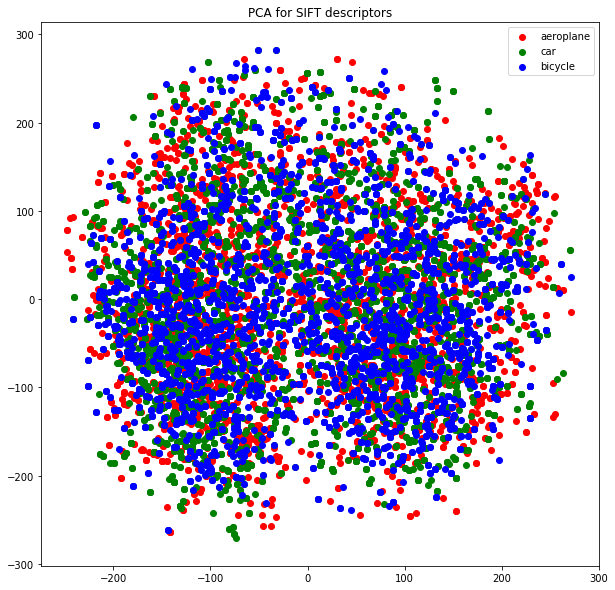

In [15]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(descriptors)

plt.figure(figsize=(10,10))
colors = ['red','green','blue']
indice_start = 0
for ni,name in enumerate(training_names):
    temp = [index for index,name_idx in enumerate(image_classes) if name_idx==ni]
    indices = [j+len(des_list[i-1])*i+indice_start if i>0 else (j+indice_start) 
               for i,ti in enumerate(temp) for j in range(len(des_list[ti]))]
    indice_start = indices[-1]
    plt.scatter(pca_result[indices,0],pca_result[indices,1], color=colors[ni], label=name)

plt.title('PCA for ' + algorithm2use + ' descriptors')
plt.legend()
plt.show()

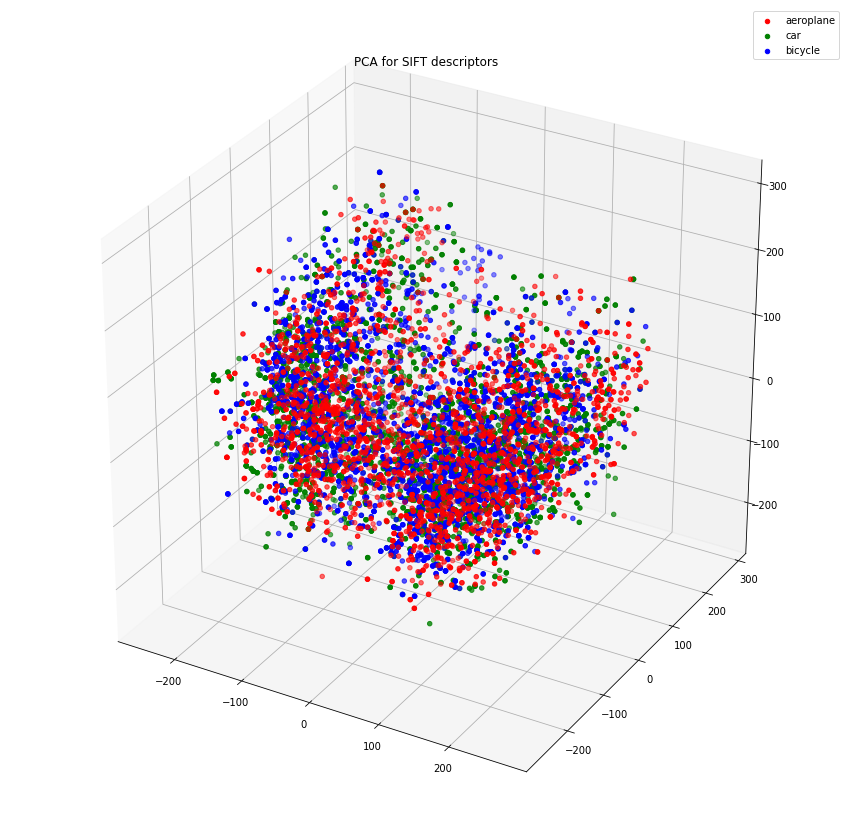

In [16]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(descriptors)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection='3d')
colors = ['red','green','blue']
indice_start = 0
for ni,name in enumerate(training_names):
    temp = [index for index,name_idx in enumerate(image_classes) if name_idx==ni]
    indices = [j+len(des_list[i-1])*i+indice_start if i>0 else (j+indice_start) 
               for i,ti in enumerate(temp) for j in range(len(des_list[ti]))]
    indice_start = indices[-1]
    ax.scatter(pca_result[indices,0],pca_result[indices,1],pca_result[indices,2], color=colors[ni], label=name)

plt.title('PCA for ' + algorithm2use + ' descriptors')
plt.legend()
plt.show()

In [17]:
voc_size = 100 # number of clusters (words in your vocabulary)

kmeans = MiniBatchKMeans(n_clusters=voc_size, 
                         init_size=voc_size*30, 
                         random_state=0, 
                         batch_size=int(descriptors.shape[0]), 
                         reassignment_ratio=0.1,
                         n_init=30,
                         max_no_improvement=50,
                         verbose=0)

In [18]:
indices = np.arange(descriptors.shape[0]) # avoids messing with descriptors array
np.random.shuffle(indices) # because we are using MiniBatchKMeans

start_time=time.time()
try:
    kmeans.fit(descriptors[indices])
except KeyboardInterrupt:
    pass
finally:
    end_time=time.time()
    print(end_time-start_time)

5.715553283691406


In [19]:
voc = kmeans.cluster_centers_

In [20]:
voc.shape,voc

((100, 128),
 array([[11.036401 , 18.653923 , 21.143778 , ...,  9.307099 , 10.397081 ,
         22.927092 ],
        [19.85883  , 19.215057 , 21.928959 , ..., 10.418034 , 19.481003 ,
         16.817589 ],
        [15.255462 , 16.728783 , 10.508385 , ..., 28.8239   ,  5.8716593,
          7.201199 ],
        ...,
        [42.770313 , 25.088724 , 17.041903 , ...,  3.4336553,  4.6304216,
          4.7697163],
        [ 8.494848 , 10.209462 , 36.676704 , ..., 17.199862 , 15.782637 ,
         17.39872  ],
        [20.437916 , 18.455025 , 22.907476 , ...,  4.0006056, 10.430046 ,
         16.93837  ]], dtype=float32))

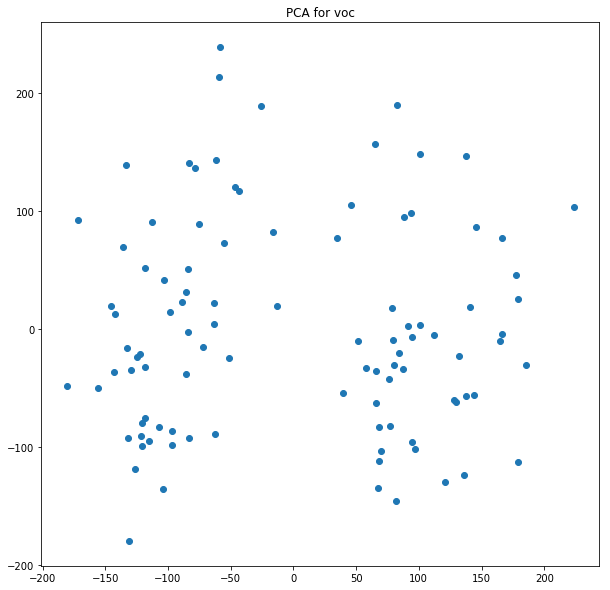

In [21]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(voc)

plt.figure(figsize=(10,10))
plt.scatter(pca_result[:,0],pca_result[:,1])
plt.title('PCA for voc')
plt.show()

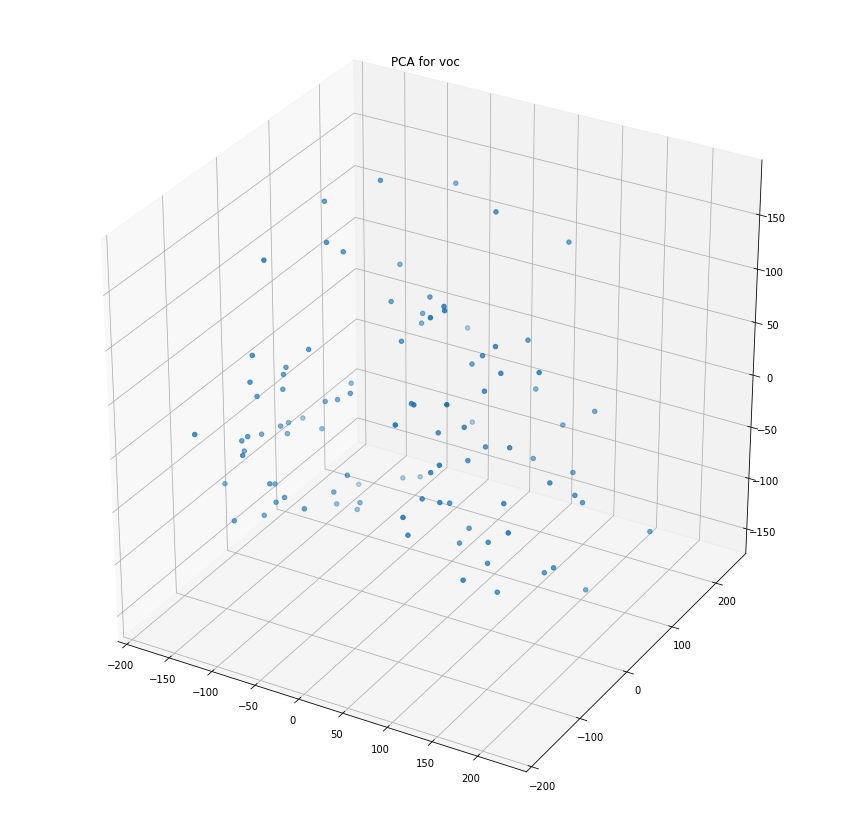

In [22]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(voc)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(pca_result[:,0],pca_result[:,1],pca_result[:,2])
plt.title('PCA for voc')
plt.show()

In [23]:
%%time
im_features = get_features(des_list, image_paths, voc)

CPU times: user 142 ms, sys: 0 ns, total: 142 ms
Wall time: 141 ms


In [24]:
im_features.shape

(46, 100)

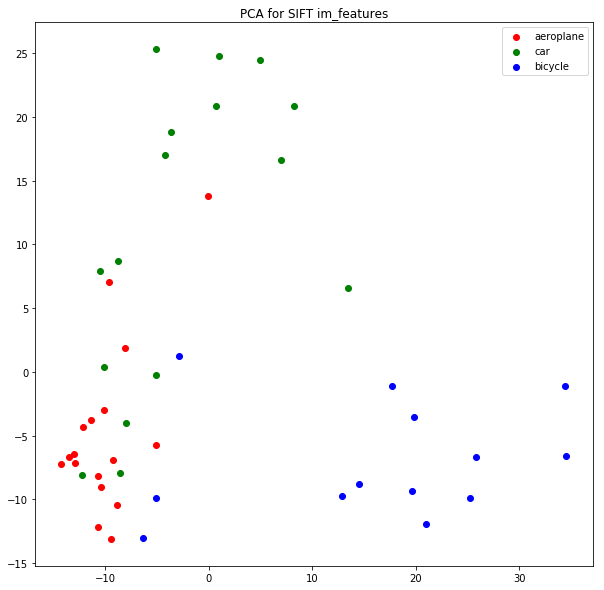

In [25]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(im_features)

plt.figure(figsize=(10,10))
colors = ['red','green','blue']
for ni,name in enumerate(training_names):
    indices = [index for index,name_idx in enumerate(image_classes) if name_idx==ni]
    plt.scatter(pca_result[indices,0],pca_result[indices,1], color=colors[ni], label=name)

plt.title('PCA for ' + algorithm2use + ' im_features')
plt.legend()
plt.show()

Nice explanation about how to use bags of words for place recognition:  
[Word Ordering and Document Adjacency for Large Loop Closure Detection in 2D Laser Maps, section II](http://www.iri.upc.edu/files/scidoc/1833-Word-ordering-and-document-adjacency-for-large-loop-closure-detection-in-2D-laser-maps.pdf)

In [20]:
total_words = im_features.sum(axis=0)

In [21]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(im_features)+1) / (1.0*nbr_occurences + 1)), 'float32')

tf_idf_database = np.zeros(im_features.shape)
for i,d in enumerate(im_features):
    for j,nw in enumerate(d):
        tf_idf_database[i,j] = idf[j]*nw/total_words[j]        

In [22]:
tf_idf_database[0] # signature of document 0

array([0.00834338, 0.        , 0.        , 0.01726732, 0.        ,
       0.00752993, 0.00397953, 0.00280466, 0.00583052, 0.00533257,
       0.        , 0.        , 0.00678494, 0.0053559 , 0.        ,
       0.00982665, 0.00975052, 0.0126966 , 0.        , 0.00346823,
       0.00350827, 0.00952315, 0.00276054, 0.00249198, 0.00432201,
       0.        , 0.00350952, 0.006777  , 0.0114857 , 0.        ,
       0.00215023, 0.        , 0.00498134, 0.0065511 , 0.00443992,
       0.00262799, 0.00386418, 0.00761796, 0.00741634, 0.0080592 ,
       0.01985533, 0.008841  , 0.00300816, 0.00621953, 0.00555476,
       0.01417738, 0.        , 0.05426871, 0.00096135, 0.00629552,
       0.        , 0.0035993 , 0.        , 0.        , 0.00987514,
       0.00425123, 0.01356461, 0.0034279 , 0.        , 0.        ,
       0.00553685, 0.00379574, 0.00271852, 0.01453315, 0.01344097,
       0.00368284, 0.00770922, 0.00776588, 0.00372915, 0.00249198,
       0.00525598, 0.00688909, 0.        , 0.00761575, 0.     

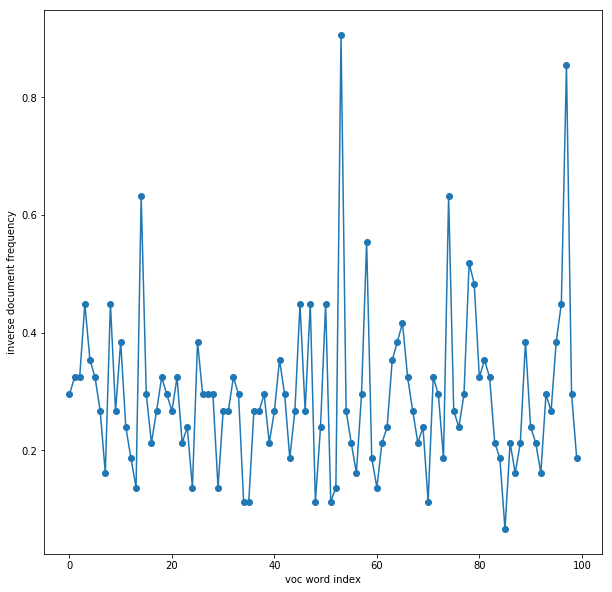

In [23]:
plt.figure(figsize=(10,10))
plt.plot(idf,'o-')
plt.xlabel('voc word index')
plt.ylabel('inverse document frequency')
plt.show()

In [24]:
# Scaling the words (Standardize features by removing the mean and scaling to unit variance)
stdSlr = StandardScaler().fit(im_features)
im_features_std = stdSlr.transform(im_features)

In [25]:
[im_features.mean(),im_features.std()],[im_features_std.mean(),im_features_std.std()]

([2.311087, 2.796653], [-6.6342563e-09, 1.0])

In [26]:
# Train the Linear SVM
clf = LinearSVC()
clf.fit(im_features_std, np.array(image_classes))

# Save the SVM
# https://scikit-learn.org/stable/modules/model_persistence.html
# joblib.dump((clf, training_names, stdSlr, k, voc), "bof.pkl", compress=3)    

# Load the classifier, class names, scaler, number of clusters and vocabulary 
# clf, classes_names, stdSlr, k, voc = joblib.load("bof.pkl")


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Testing

In [27]:
# Get the training classes names and store them in a list
test_path = "dataset/test"
testing_names = os.listdir(train_path)

In [28]:
testing_names

['aeroplane', 'car', 'bicycle']

In [29]:
test_image_paths, test_image_classes = get_data(test_path, testing_names)

In [30]:
%%time
des_list, kpts_list = get_descriptors(test_image_paths, fea_det)

CPU times: user 332 ms, sys: 19.1 ms, total: 351 ms
Wall time: 181 ms


In [31]:
descriptors = np.concatenate(des_list)

In [32]:
%%time
test_features = get_features(des_list, test_image_paths, voc)

CPU times: user 28.3 ms, sys: 213 µs, total: 28.5 ms
Wall time: 27.5 ms


### Using the linear SVM

In [33]:
# Scale the features
test_features_std = stdSlr.transform(test_features)

In [34]:
predictions =  [training_names[i] for i in clf.predict(test_features_std)]

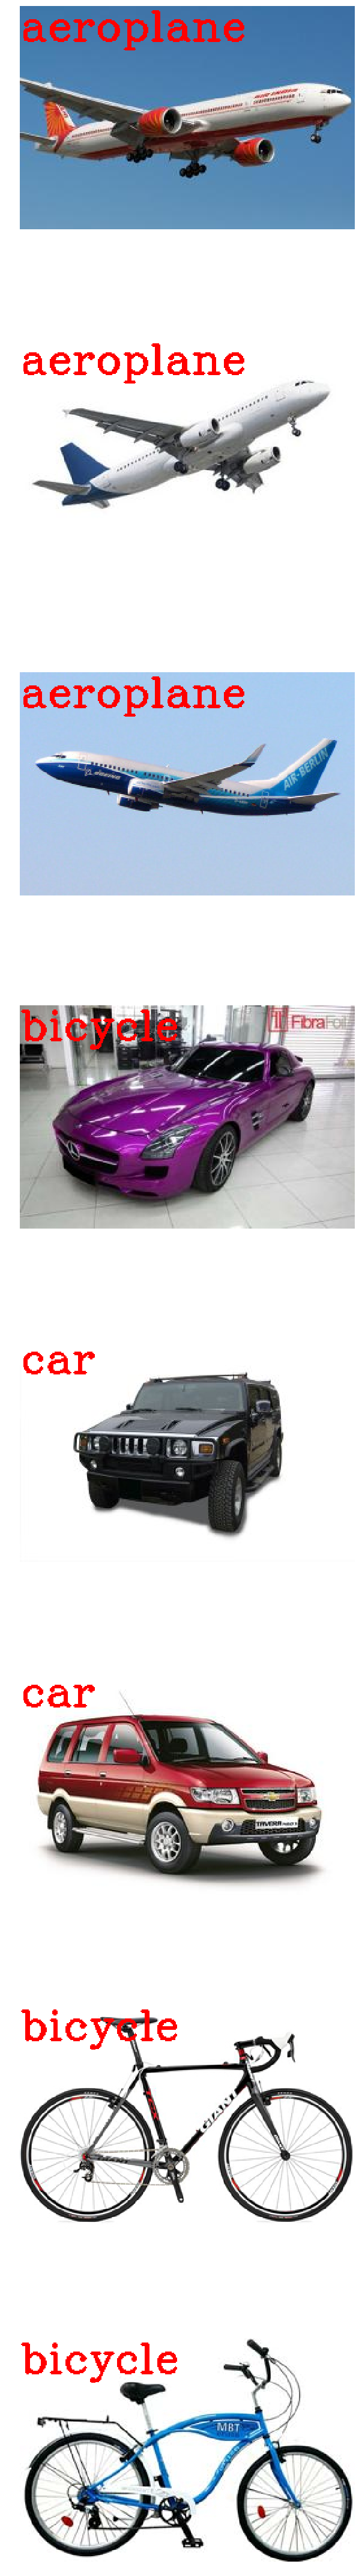

In [35]:
plt.figure(figsize=(10,10*len(predictions)))
for i,(image_path, prediction) in enumerate(zip(test_image_paths, predictions)):
    image = cv2.imread(image_path)
    cv2.putText(image, prediction, (0,30) ,cv2.FONT_HERSHEY_COMPLEX, 1.2, [0, 0, 255], 2)
    image = image[..., ::-1]
    
    plt.subplot(len(predictions),1,1+i)
    plt.imshow(image)
    plt.axis('off')

plt.show()

### Now using the tf-idf

In [36]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(test_features)+1) / (1.0*nbr_occurences + 1)), 'float32')

tf_idf_test = np.zeros(test_features.shape)
for i,d in enumerate(test_features):
    for j,nw in enumerate(d):
        tf_idf_test[i,j] = idf[j]*nw/total_words[j]

In [37]:
tf_idf_test[0] 

array([0.00222232, 0.        , 0.        , 0.        , 0.00633539,
       0.        , 0.01210344, 0.0010242 , 0.        , 0.00502629,
       0.        , 0.00862692, 0.01068703, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01431053,
       0.00464933, 0.        , 0.00526578, 0.        , 0.00477179,
       0.0036958 , 0.00299184, 0.00577734, 0.        , 0.00235566,
       0.        , 0.        , 0.00452144, 0.00450517, 0.00232466,
       0.00330233, 0.        , 0.        , 0.00148155, 0.00768654,
       0.01336779, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01431053, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00465397,
       0.00502629, 0.00110078, 0.00584452, 0.00628286, 0.00512887,
       0.00159166, 0.        , 0.00571169, 0.        , 0.02466238,
       0.        , 0.01930786, 0.00228705, 0.        , 0.00613453,
       0.00220155, 0.        , 0.00120187, 0.0124122 , 0.     

In [38]:
distances2database = np.zeros((tf_idf_test.shape[0],tf_idf_database.shape[0]))
for i,si in enumerate(tf_idf_test):
    for j,sj in enumerate(tf_idf_database):
        distances2database[i,j] = cdist([si],[sj], metric='cosine')
    

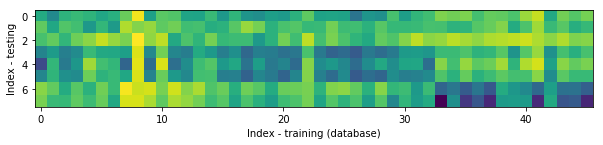

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(distances2database)
plt.xlabel("Index - training (database)")
plt.ylabel("Index - testing")
plt.show()

In [40]:
best_matches = distances2database.argmin(axis=1)

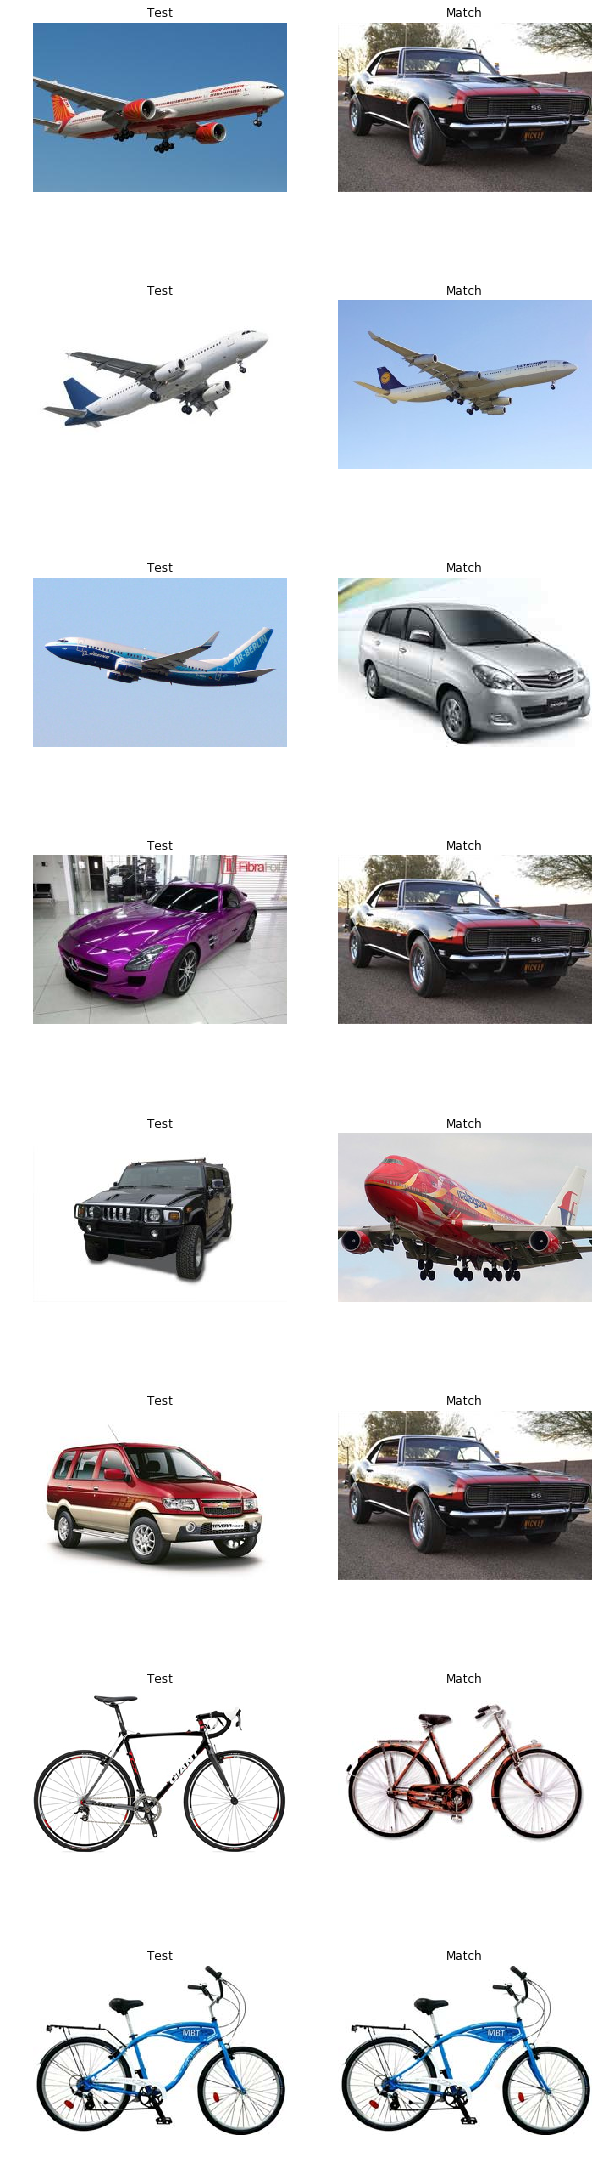

In [41]:
plt.figure(figsize=(10,5*len(best_matches)))
for i,(image_path, prediction) in enumerate(zip(test_image_paths, best_matches)):    
    plt.subplot(len(best_matches),2,1+2*i)
    image = cv2.imread(image_path)[..., ::-1]
    plt.imshow(image)
    plt.title("Test")
    plt.axis('off')
    
    plt.subplot(len(best_matches),2,2+2*i)
    image = cv2.imread(image_paths[prediction])[..., ::-1]
    plt.imshow(image)
    plt.title("Match")
    plt.axis('off')    

plt.show()

## Testing on any image URL!

In [42]:
from urllib.request import urlopen
from PIL import Image

In [43]:
url = "https://www.e-zrentacar.com/wp-content/plugins/advantage-vehicles/assets/SCAR_800x400.png"

### Using the linear SVM

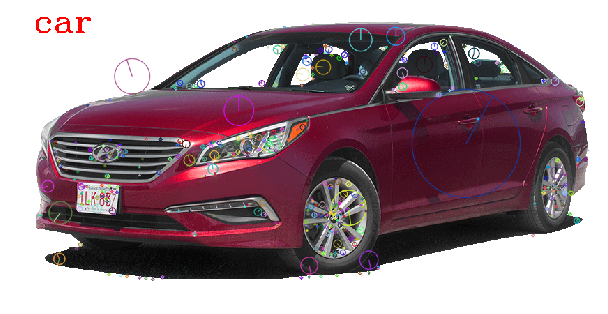

In [44]:
image_test = np.asarray(Image.open(urlopen(url)))[:,:,:3]

image = image_test[..., ::-1] # the system was trained using BGR (OpenCV default format)
kpts = fea_det.detect(image)
kpts, des = fea_det.compute(image, kpts)

words, distance = vq(des, voc)
im_features = np.bincount(words, minlength=voc.shape[0])

im_features = stdSlr.transform([im_features])

prediction =  testing_names[clf.predict(im_features)[0]] 


plt.figure(figsize=(10,10))

image = cv2.drawKeypoints(image, kpts, image_test, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.putText(image, prediction, (0,30) ,cv2.FONT_HERSHEY_COMPLEX, 1.5, [0, 0, 255], 2)
image = image.get()[..., ::-1]

plt.imshow(image)
plt.axis('off')

plt.show()

### Now using the tf-idf

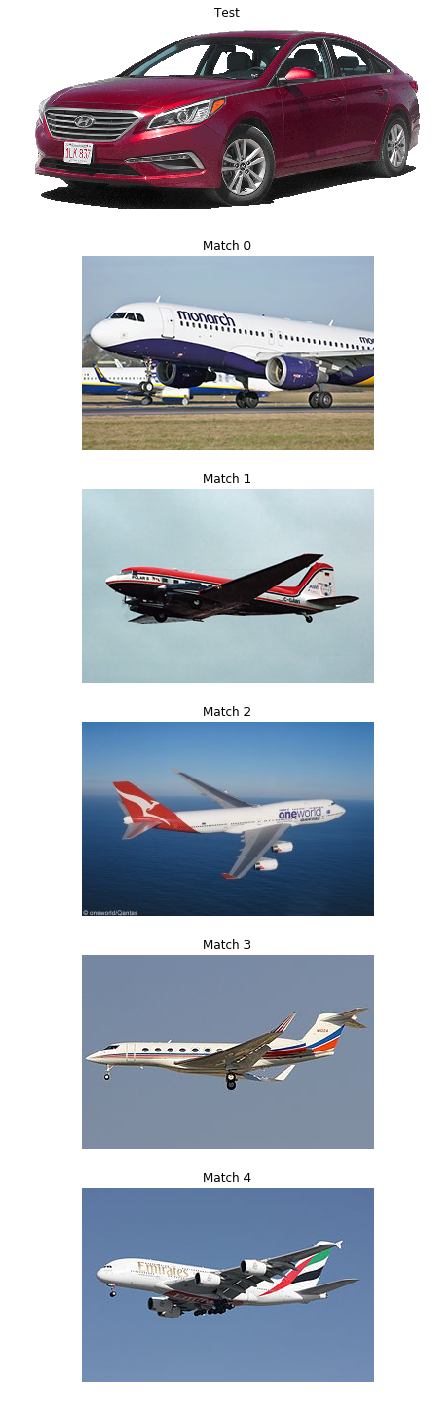

In [45]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(im_features)+1) / (1.0*nbr_occurences + 1)), 'float32')

tf_idf_test = np.zeros(im_features.shape)
for i,d in enumerate(im_features):
    for j,nw in enumerate(d):
        tf_idf_test[i,j] = idf[j]*nw/total_words[j]

distances2database = np.zeros((tf_idf_test.shape[0],tf_idf_database.shape[0]))
for i,si in enumerate(tf_idf_test):
    for j,sj in enumerate(tf_idf_database):
        distances2database[i,j] = cdist([si],[sj], metric='cosine')
        
best_matches = distances2database.argsort(axis=1)[0][:5]

plt.figure(figsize=(10,5*len(best_matches)))

plt.subplot(len(best_matches)+1,1,1)
plt.imshow(image_test)
plt.title("Test")
plt.axis('off')

for i, prediction in enumerate(best_matches):
    plt.subplot(len(best_matches)+1,1,2+i)
    image = cv2.imread(image_paths[prediction])[..., ::-1]
    plt.imshow(image)
    plt.title("Match " + str(i))
    plt.axis('off')    

plt.show()